In [1]:
import pandas as pd
import numpy as np
# 1.0 Load ratings and keep only necessary columns
ratings = pd.read_csv(r"..\..\..\Dataset\ratings.csv")  
ratings = ratings[['userId', 'movieId', 'rating']]

In [2]:
#randomly select 100 users with more than 50 ratings each.
# Count how many ratings each user has
user_counts = ratings['userId'].value_counts()
# Keep only users who have more than 50 ratings
eligible_users = user_counts[user_counts > 50].index
# Randomly select 100 users
np.random.seed(42)
selected_users = np.random.choice(eligible_users, 100, replace=False)
print("Number of users with > 50 ratings:", len(eligible_users))
print("First 10 selected cold-start users:", selected_users[:10])

Number of users with > 50 ratings: 84056
First 10 selected cold-start users: [ 19320 102055 120201  78986     21 103558   3057   8663   6361  63053]


In [3]:
# 1.2 For each selected user, hide 80% of their ratings and  Store the hidden ratings as ground truth for evaluation.

# Work on a copy so original ratings remain unchanged
ratings_cold_users = ratings.copy()
hidden_user_ratings = []
for user in selected_users:
    # All rows where this user rated something
    user_indices = ratings_cold_users[ratings_cold_users['userId'] == user].index
    
    # Number of ratings to hide (80%)
    n_hide = int(len(user_indices) * 0.8)
    
    # Randomly choose which ratings to hide
    hide_idx = np.random.choice(user_indices, n_hide, replace=False)
    
    # Save the hidden ratings for evaluation (ground truth)
    hidden_user_ratings.append(ratings_cold_users.loc[hide_idx])
    
    # Hide ratings by replacing them with NaN
    ratings_cold_users.loc[hide_idx, 'rating'] = np.nan

# Convert list of hidden ratings to a single DataFrame
hidden_user_ratings = pd.concat(hidden_user_ratings, ignore_index=True)

print("Hidden user ratings (ground truth) shape:", hidden_user_ratings.shape)

# Quick sanity check: show how many ratings remain visible for first few cold-start users
for user in selected_users[:10]:
    remaining = ratings_cold_users[
        ratings_cold_users['userId'] == user
    ]['rating'].notna().sum()
    print(f"User {user} remaining visible ratings:", remaining)


Hidden user ratings (ground truth) shape: (15325, 3)
User 19320 remaining visible ratings: 24
User 102055 remaining visible ratings: 158
User 120201 remaining visible ratings: 14
User 78986 remaining visible ratings: 34
User 21 remaining visible ratings: 33
User 103558 remaining visible ratings: 70
User 3057 remaining visible ratings: 61
User 8663 remaining visible ratings: 34
User 6361 remaining visible ratings: 16
User 63053 remaining visible ratings: 42


In [4]:
# Visible ratings after hiding 80% for cold-start users
visible_ratings = ratings_cold_users.dropna(subset=['rating']).reset_index(drop=True)
# This is the dataset you will use as the starting point for item cold-start
ratings_train = visible_ratings.copy()
print("Visible ratings after user hiding:", len(visible_ratings))
print("Training data users:", ratings_train['userId'].nunique())
print("Training data items:", ratings_train['movieId'].nunique())

Visible ratings after user hiding: 19984938
Training data users: 138493
Training data items: 26742


In [5]:
# 1.4 Similarly, select 50 items with many ratings.
# Count ratings per item using ratings_train (after user hiding)
item_counts = ratings_train['movieId'].value_counts()
# Items with more than 50 ratings (you can increase this threshold if needed)
eligible_items = item_counts[item_counts > 50].index
# Randomly select 50 items
np.random.seed(42)
selected_items = np.random.choice(eligible_items, 50, replace=False)
print("Number of items with > 50 ratings:", len(eligible_items))
print("First 10 selected cold-start items:", selected_items[:10])

Number of items with > 50 ratings: 10472
First 10 selected cold-start items: [ 77854   6571   2606   3132  94130  96667 105197   1082  98361   3577]


In [6]:
# 1.4 Hide most ratings for the selected items to simulate cold-start items.
#     Store hidden ratings as ground truth and update training data.
hidden_item_ratings = []
def hide_item_ratings(df, items, keep_min=10, keep_max=20):
    df_copy = df.copy()
    for m in items:
        item_idx = df_copy[df_copy['movieId'] == m].index
        n_total = len(item_idx)
        if n_total <= keep_min:
            # too few ratings to hide safely
            continue

        # choose how many to KEEP visible (between keep_min and keep_max,
        # roughly ~20% of ratings but clipped)
        n_keep = min(max(keep_min, int(0.2 * n_total)), keep_max)
        keep_idx = np.random.choice(item_idx, n_keep, replace=False)
        hide_idx = np.setdiff1d(item_idx, keep_idx)

        # store hidden ratings as ground truth for items
        hidden_item_ratings.append(df_copy.loc[hide_idx])

        # mark hidden ratings as missing in the training data
        df_copy.loc[hide_idx, 'rating'] = np.nan

    return df_copy

# Apply hiding on ratings_train (which already has user cold-start hidden)
ratings_cold_items = hide_item_ratings(ratings_train, selected_items)

# Final item ground-truth DataFrame
hidden_item_ratings = pd.concat(hidden_item_ratings, ignore_index=True)

print("Hidden item ratings (ground truth) shape:", hidden_item_ratings.shape)

# Visible ratings after hiding for BOTH cold-start users and items
visible_ratings_final = ratings_cold_items.dropna(subset=['rating']).reset_index(drop=True)
ratings_train_final = visible_ratings_final.copy()

print("Final training ratings (after user + item hiding):", len(ratings_train_final))
print("Final training users:", ratings_train_final['userId'].nunique())
print("Final training items:", ratings_train_final['movieId'].nunique())


Hidden item ratings (ground truth) shape: (157655, 3)
Final training ratings (after user + item hiding): 19827283
Final training users: 138493
Final training items: 26742


In [7]:
# example definition from Part 1 
user_stats = ratings_train_final.groupby('userId')['rating'].mean().reset_index(name='mean_rating')
global_mean = user_stats['mean_rating'].mean()
global_std  = user_stats['mean_rating'].std()
user_stats['z_score'] = (user_stats['mean_rating'] - global_mean) / global_std
user_feature_vector = user_stats[['userId', 'z_score']]


In [8]:
# 2.1 limited profile features (z_score) for cold-start users

# mean rating per cold-start user from their visible ratings
cold_means = (
    ratings_train_final[ratings_train_final['userId'].isin(selected_users)]
    .groupby('userId')['rating']
    .mean()
    .reset_index(name='mean_rating')
)

# reuse the SAME global_mean and global_std as above
cold_means['z_score'] = (cold_means['mean_rating'] - global_mean) / global_std

cold_user_features = cold_means[['userId', 'z_score']].copy()
print("Cold-start user features (first 5):")
print(cold_user_features.head())


Cold-start user features (first 5):
   userId   z_score
0      21  0.093513
1    1899 -2.191391
2    2254  0.265397
3    3057  0.469510
4    5615  0.293021


In [9]:
from numpy.linalg import norm
import numpy as np

user_centroids = pd.read_csv('../part1/user_centroids_k5.csv')
# 2.2 distances from each cold-start user to each centroid
cold_z = cold_user_features['z_score'].values.reshape(-1, 1)  # shape (n_cold, 1)

distances_to_centroids = []
for i in range(len(cold_z)):
    x = cold_z[i]                    # shape (1,)
    # broadcast subtraction over all centroids
    dists = np.sqrt(np.sum((user_centroids - x)**2, axis=1))  # shape (k_best,)
    distances_to_centroids.append(dists)

distances_to_centroids = np.vstack(distances_to_centroids)     # (n_cold, k_best)
print("Distances shape:", distances_to_centroids.shape)
print("Distances for first cold user:", distances_to_centroids[0])


Distances shape: (100, 5)
Distances for first cold user: [2.57765059 0.46851338 0.28943053 1.35123391 1.15744619]


In [10]:
assigned_clusters = []
nearest_dists = []
second_dists = []
confidences = []

for i, u_id in enumerate(cold_user_features['userId'].values):
    dists = distances_to_centroids[i]
    order = np.argsort(dists)
    nearest = order[0]
    second = order[1]
    d_near = dists[nearest]
    d_sec = dists[second]
    conf = (d_sec - d_near) / d_sec if d_sec > 0 else 0.0

    assigned_clusters.append(nearest)
    nearest_dists.append(d_near)
    second_dists.append(d_sec)
    confidences.append(conf)

cold_user_assignment = cold_user_features.copy()
cold_user_assignment['assigned_cluster'] = assigned_clusters
cold_user_assignment['d_nearest'] = nearest_dists
cold_user_assignment['d_second'] = second_dists
cold_user_assignment['confidence'] = confidences

print("Cold-start user assignments (first 10):")
print(cold_user_assignment.head(10))
print("Confidence range:",
      cold_user_assignment['confidence'].min(),
      "to",
      cold_user_assignment['confidence'].max())


Cold-start user assignments (first 10):
   userId   z_score  assigned_cluster  d_nearest  d_second  confidence
0      21  0.093513                 2   0.289431  0.468513    0.382236
1    1899 -2.191391                 0   0.292746  1.127458    0.740348
2    2254  0.265397                 1   0.296629  0.461315    0.356992
3    3057  0.469510                 1   0.092517  0.665427    0.860967
4    5615  0.293021                 1   0.269005  0.488939    0.449819
5    5813 -0.682739                 4   0.381195  0.486821    0.216972
6    6361 -0.987478                 4   0.076455  0.791560    0.903412
7    6513 -0.094486                 2   0.101432  0.656512    0.845498
8    8396 -0.579324                 2   0.383406  0.484610    0.208835
9    8663 -1.205386                 4   0.141452  1.009468    0.859875
Confidence range: 0.005639222926996325 to 0.9883115954611299


In [11]:
# Custom K-means implementation (copied from Part 1)

import numpy as np

def kmeans(features, k, max_iters=100, tol=1e-4, random_state=42):
    np.random.seed(random_state)
    n_samples = features.shape[0]

    # Step 1: Initialize centroids randomly from the data points
    random_indices = np.random.choice(n_samples, k, replace=False)
    centroids = features[random_indices].copy()

    for iteration in range(max_iters):
        # Step 2: Assign each point to nearest centroid
        distances = np.zeros((n_samples, k))
        for i in range(k):
            # Euclidean distance
            distances[:, i] = np.sqrt(np.sum((features - centroids[i])**2, axis=1))

        labels = np.argmin(distances, axis=1)

        # Step 3: Update centroids
        new_centroids = np.zeros_like(centroids)
        for i in range(k):
            cluster_points = features[labels == i]
            if len(cluster_points) > 0:
                new_centroids[i] = np.mean(cluster_points, axis=0)
            else:
                # If cluster is empty, reinitialize centroid
                new_centroids[i] = features[np.random.choice(n_samples)]

        # Step 4: Check for convergence
        centroid_shift = np.sqrt(np.sum((new_centroids - centroids)**2))
        centroids = new_centroids
        if centroid_shift < tol:
            print(f"  Converged at iteration {iteration + 1}")
            break

    # Sum of squared distances to nearest centroid (inertia)
    inertia = 0.0
    for i in range(n_samples):
        inertia += np.sum((features[i] - centroids[labels[i]])**2)

    return centroids, labels, inertia


In [12]:
# === minimal user clustering re-used for Points 2 and 3 ===

# build user_feature_vector on ratings_train_final
user_stats = ratings_train_final.groupby('userId')['rating'].mean().reset_index(name='mean_rating')
global_mean = user_stats['mean_rating'].mean()
global_std  = user_stats['mean_rating'].std()
user_stats['z_score'] = (user_stats['mean_rating'] - global_mean) / global_std

user_feature_vector = user_stats[['userId', 'z_score']].copy()

# run your custom kmeans
features = user_feature_vector[['z_score']].values
k_values = [5, 10, 15, 20, 30, 50]
results = {}

for k in k_values:
    centroids, labels, inertia = kmeans(features, k, max_iters=100, random_state=42)
    results[k] = {'centroids': centroids, 'labels': labels, 'inertia': inertia}
    avg_cluster_size = len(labels) / k
    print(f"K={k} | Inertia={inertia:.4f} , Avg Cluster Size={avg_cluster_size:.1f}")

# choose your k (e.g., 5)
k_best = 5
user_centroids = results[k_best]['centroids']
user_labels    = results[k_best]['labels']

print("User centroids shape:", user_centroids.shape)
print("user_feature_vector rows:", len(user_feature_vector))
print("user_labels length:", len(user_labels))


  Converged at iteration 50
K=5 | Inertia=13611.6339 , Avg Cluster Size=27698.6
K=10 | Inertia=3979.1694 , Avg Cluster Size=13849.3
K=15 | Inertia=1930.2379 , Avg Cluster Size=9232.9
K=20 | Inertia=1209.7556 , Avg Cluster Size=6924.6
K=30 | Inertia=646.7339 , Avg Cluster Size=4616.4
K=50 | Inertia=346.4692 , Avg Cluster Size=2769.9
User centroids shape: (5, 1)
user_feature_vector rows: 138493
user_labels length: 138493


In [13]:
import numpy as np
import pandas as pd

# Map userId -> cluster id (from your clustering step)
user_cluster_map = pd.DataFrame({
    'userId': user_feature_vector['userId'].values,
    'cluster': user_labels
})

print("User-cluster map rows:", len(user_cluster_map))

def cosine_similarity_on_overlap_series(u_series, v_series, min_overlap=3):
    common = u_series.index.intersection(v_series.index)
    if len(common) < min_overlap:
        return 0.0
    a = u_series.loc[common].values
    b = v_series.loc[common].values
    num = np.dot(a, b)
    den = np.linalg.norm(a) * np.linalg.norm(b)
    return float(num / den) if den > 0 else 0.0


User-cluster map rows: 138493


In [14]:
cold_users_set = set(selected_users)

# sample, e.g., 3000 extra users to act as neighbors
other_users = (
    ratings_train_final[~ratings_train_final['userId'].isin(cold_users_set)]
    ['userId'].drop_duplicates()
)

np.random.seed(42)
sample_other_users = other_users.sample(n=3000, replace=False)

keep_users = list(cold_users_set) + sample_other_users.tolist()

ratings_train_small = ratings_train_final[
    ratings_train_final['userId'].isin(keep_users)
].reset_index(drop=True)

print("ratings_train_small rows:", len(ratings_train_small))
print("users in small set:", ratings_train_small['userId'].nunique())


ratings_train_small rows: 430199
users in small set: 3100


Menna salem elsayed 221101277


In [15]:
import pandas as pd
import numpy as np
item_stats = (
    ratings_train_final
    .groupby('movieId')['rating']
    .agg(
        num_raters='count',
        avg_rating='mean',
        std_rating='std'
    )
    .fillna(0)
    .reset_index()
)


In [16]:
# compute means and stds
item_means = item_stats[['num_raters', 'avg_rating', 'std_rating']].mean()
item_stds  = item_stats[['num_raters', 'avg_rating', 'std_rating']].std()

item_features_z = (item_stats[['num_raters', 'avg_rating', 'std_rating']] - item_means) / item_stds

In [17]:
item_feature_vector = item_features_z.copy()
item_feature_vector['movieId'] = item_stats['movieId'].values


In [18]:
# feature matrix
X_items = item_feature_vector[['num_raters', 'avg_rating', 'std_rating']].values

# choose K (same idea as Part 3)
k_items = 5

item_centroids, item_labels, item_inertia = kmeans(X_items, k_items, random_state=42)

print("Item clustering DONE")
print("Number of items:", len(item_labels))
print("Number of clusters:", k_items)


  Converged at iteration 24
Item clustering DONE
Number of items: 26742
Number of clusters: 5


In [19]:
item_cluster_map = pd.DataFrame({
    'movieId': item_feature_vector['movieId'].values,
    'cluster': item_labels
})

In [20]:
features_items = item_feature_vector[['num_raters', 'avg_rating', 'std_rating']].values

In [21]:
# Using your chosen k ( k_items = 5)
item_centroids, item_labels, _ = kmeans(features_items, k_items, random_state=42)

item_clustered = item_feature_vector.copy()
item_clustered['cluster'] = item_labels

  Converged at iteration 24


In [22]:
cluster_counts = item_clustered['cluster'].value_counts().sort_index()
print(cluster_counts)


cluster
0    12754
1      441
2     1248
3     5149
4     7150
Name: count, dtype: int64


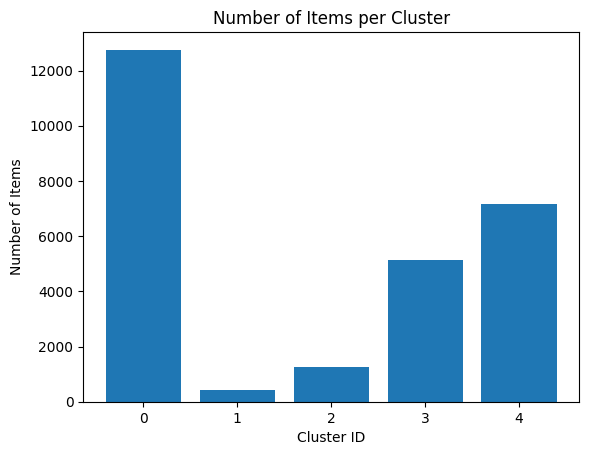

In [23]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster ID')
plt.ylabel('Number of Items')
plt.title('Number of Items per Cluster')
plt.show()


Generate recommendations involving cold-start items


In [24]:
# 1) itemId -> cluster id (from your item K-means)
item_cluster_map = pd.DataFrame({
    'movieId': item_feature_vector['movieId'].values,
    'cluster': item_labels
})

# cluster -> list of items
cluster_items = (
    item_cluster_map
    .groupby('cluster')['movieId']
    .apply(list)
    .to_dict()
)

print("Clusters:", {c: len(v) for c, v in cluster_items.items()})


Clusters: {0: 12754, 1: 441, 2: 1248, 3: 5149, 4: 7150}


In [25]:
import numpy as np
import pandas as pd
import time

item_ratings = {}
for m, g in ratings_train_final.groupby('movieId'):
    item_ratings[m] = g.set_index('userId')['rating']

print("Items in item_ratings:", len(item_ratings))

# 6.x PREP-2: similarity cache (min_id, max_id) -> similarity
sim_cache = {}

def cosine_similarity_items_cached(m1, m2, min_overlap=3):

    key = (m1, m2) if m1 < m2 else (m2, m1)
    if key in sim_cache:
        return sim_cache[key]
    
    s1 = item_ratings.get(m1)
    s2 = item_ratings.get(m2)
    if s1 is None or s2 is None:
        sim_cache[key] = 0.0
        return 0.0
    
    common = s1.index.intersection(s2.index)
    if len(common) < min_overlap:
        sim_cache[key] = 0.0
        return 0.0
    
    a = s1.loc[common].values
    b = s2.loc[common].values
    num = np.dot(a, b)
    den = np.linalg.norm(a) * np.linalg.norm(b)
    sim = float(num / den) if den > 0 else 0.0
    sim_cache[key] = sim
    return sim


# 6.1 + 6.2: Predict ratings for users using similar items
#           within the same cluster

def fast_predictions_for_cold_item(i_cold, min_overlap=3):

    # 6.2 – find cluster of the cold item
    row = item_cluster_map[item_cluster_map['movieId'] == i_cold]
    if row.empty:
        return None
    c = row['cluster'].iloc[0]
    
    # items in the same cluster (neighbors), excluding the cold item
    items_same_cluster = [m for m in cluster_items[c] if m != i_cold]
    if not items_same_cluster:
        return None
    
    # precompute similarities i_cold vs each neighbor item
    sims = []
    for j in items_same_cluster:
        s_ij = cosine_similarity_items_cached(i_cold, j, min_overlap=min_overlap)
        if s_ij != 0.0:
            sims.append((j, s_ij))
    
    if not sims:
        return None
    
    sim_df = pd.DataFrame(sims, columns=['movieId_neighbor', 'sim'])
    
    # ratings for neighbor items only
    df_neighbors = ratings_train_final[
        ratings_train_final['movieId'].isin(sim_df['movieId_neighbor'])
    ].copy()
    
    # attach similarity values
    df_neighbors = df_neighbors.merge(
        sim_df,
        left_on='movieId',
        right_on='movieId_neighbor',
        how='inner'
    )
    
    # weighted sum per user
    df_neighbors['weighted'] = df_neighbors['rating'] * df_neighbors['sim']
    user_agg = df_neighbors.groupby('userId').agg(
        numer=('weighted', 'sum'),
        denom=('sim', lambda x: np.abs(x).sum())
    ).reset_index()
    
    # keep only users with non-zero denominator
    user_agg = user_agg[user_agg['denom'] > 0]
    if user_agg.empty:
        return None
    
    # 6.1 – predicted rating for cold-start item
    user_agg['pred_rating'] = user_agg['numer'] / user_agg['denom']
    user_agg['movieId'] = i_cold
    
    return user_agg[['userId', 'movieId', 'pred_rating']]


# 6.3: Identify users who would most likely rate the item highly

cold_items_list = list(selected_items)[:50]  
cold_item_recommendations = []

start_time = time.time()

for idx, i_cold in enumerate(cold_items_list, start=1):
    item_start = time.time()
    
    preds_df = fast_predictions_for_cold_item(i_cold, min_overlap=3)
    if preds_df is None or preds_df.empty:
        print(f"[{idx}/{len(cold_items_list)}] Item {i_cold}: no predictions (skipped)")
        continue
    
    # sort users by predicted rating (highest first)
    preds_df = preds_df.sort_values('pred_rating', ascending=False)
    
    # top-20 users = those most likely to rate the cold item highly
    top_users_for_item = preds_df.head(20).copy()
    cold_item_recommendations.append(top_users_for_item)
    
    item_end = time.time()
    print(f"[{idx}/{len(cold_items_list)}] Item {i_cold}: "
          f"{len(preds_df)} users predicted, "
          f"time = {item_end - item_start:.2f} sec")

end_time = time.time()

# combine all results
if cold_item_recommendations:
    cold_item_recommendations = pd.concat(cold_item_recommendations, ignore_index=True)
    
    # optional: add rank within each item for clarity
    cold_item_recommendations['rank'] = (
        cold_item_recommendations
        .groupby('movieId')['pred_rating']
        .rank(method='first', ascending=False)
    )
    
    cold_item_recommendations = cold_item_recommendations[
        ['movieId', 'userId', 'pred_rating', 'rank']
    ].sort_values(['movieId', 'rank'])
    
    print("\nSample of users most likely to rate cold-start items highly:")
    print(cold_item_recommendations.head(20))
else:
    print("\nNo recommendations generated for any cold-start item.")

print(f"\nTotal runtime for full cold-start item recommendation step: "
      f"{end_time - start_time:.2f} seconds")


Items in item_ratings: 26742
[1/50] Item 77854: 126356 users predicted, time = 15.36 sec
[2/50] Item 6571: 127173 users predicted, time = 15.37 sec
[3/50] Item 2606: 104013 users predicted, time = 10.58 sec
[4/50] Item 3132: 129833 users predicted, time = 16.96 sec
[5/50] Item 94130: 126512 users predicted, time = 17.44 sec
[6/50] Item 96667: 124070 users predicted, time = 14.69 sec
[7/50] Item 105197: 128592 users predicted, time = 15.87 sec
[8/50] Item 1082: 125545 users predicted, time = 14.41 sec
[9/50] Item 98361: 123298 users predicted, time = 15.00 sec
[10/50] Item 3577: 102256 users predicted, time = 11.96 sec
[11/50] Item 70093: 95860 users predicted, time = 11.21 sec
[12/50] Item 5563: 130782 users predicted, time = 17.09 sec
[13/50] Item 6636: 130379 users predicted, time = 17.37 sec
[14/50] Item 3247: 85610 users predicted, time = 10.23 sec
[15/50] Item 5466: 128932 users predicted, time = 17.50 sec
[16/50] Item 5587: 103778 users predicted, time = 12.38 sec
[17/50] Item 90

6.1 For users who might be interested in the cold-start item, predict their ratings.

In [26]:
#  movieId -> movie (userId -> rating)
item_ratings = {}
for m, g in ratings_train_final.groupby('movieId'):
    item_ratings[m] = g.set_index('userId')['rating']

print("Items in item_ratings:", len(item_ratings))


Items in item_ratings: 26742


6.2 Item–item similarity inside a cluster

In [27]:
import numpy as np

# (min_id, max_id) -> similarity
sim_cache = {}

def cosine_similarity_items_cached(m1, m2, min_overlap=3):
    key = (m1, m2) if m1 < m2 else (m2, m1)
    if key in sim_cache:
        return sim_cache[key]
    
    s1 = item_ratings.get(m1)
    s2 = item_ratings.get(m2)
    if s1 is None or s2 is None:
        sim_cache[key] = 0.0
        return 0.0
    
    common = s1.index.intersection(s2.index)
    if len(common) < min_overlap:
        sim_cache[key] = 0.0
        return 0.0
    
    a = s1.loc[common].values
    b = s2.loc[common].values
    num = np.dot(a, b)
    den = np.linalg.norm(a) * np.linalg.norm(b)
    sim = float(num / den) if den > 0 else 0.0
    sim_cache[key] = sim
    return sim



Generate recommendations & find “most likely” users

In [28]:
import pandas as pd

def fast_predictions_for_cold_item(i_cold, min_overlap=3):

    # 3.1 Find cluster of the cold item
    row = item_cluster_map[item_cluster_map['movieId'] == i_cold]
    if row.empty:
        return None
    c = row['cluster'].iloc[0]
    
    # 3.2 Items in the same cluster (neighbors)
    items_same_cluster = [m for m in cluster_items[c] if m != i_cold]
    if not items_same_cluster:
        return None
    
    # 3.3 Precompute similarities cold item vs each neighbor
    sims = []
    for j in items_same_cluster:
        s_ij = cosine_similarity_items_cached(i_cold, j, min_overlap=min_overlap)
        if s_ij != 0.0:
            sims.append((j, s_ij))
    
    if not sims:
        return None
    
    sim_df = pd.DataFrame(sims, columns=['movieId_neighbor', 'sim'])
    
    # 3.4 Take all ratings of those neighbor items
    df_neighbors = ratings_train_final[
        ratings_train_final['movieId'].isin(sim_df['movieId_neighbor'])
    ].copy()
    
    # add similarity column by joining
    df_neighbors = df_neighbors.merge(
        sim_df,
        left_on='movieId',
        right_on='movieId_neighbor',
        how='inner'
    )
    
    # 3.5 Weighted sums per user
    df_neighbors['weighted'] = df_neighbors['rating'] * df_neighbors['sim']
    user_agg = df_neighbors.groupby('userId').agg(
        numer=('weighted', 'sum'),
        denom=('sim', lambda x: np.abs(x).sum())
    ).reset_index()
    
    user_agg = user_agg[user_agg['denom'] > 0]
    if user_agg.empty:
        return None
    
    user_agg['pred_rating'] = user_agg['numer'] / user_agg['denom']
    user_agg['movieId'] = i_cold   # add cold item id
    
    return user_agg[['userId', 'movieId', 'pred_rating']]



In [29]:
import time
import pandas as pd

cold_items_list = list(selected_items)[:50]

cold_item_recommendations = []

start_time = time.time()

for idx, i_cold in enumerate(cold_items_list, start=1):
    item_start = time.time()
    
    # Get predictions for this cold-start item using the fast function
    preds_df = fast_predictions_for_cold_item(i_cold, min_overlap=3)
    
    if preds_df is None or preds_df.empty:
        print(f"[{idx}/{len(cold_items_list)}] Item {i_cold}: no predictions (skipped)")
        continue
    
    # Sort by predicted rating descending
    preds_df = preds_df.sort_values('pred_rating', ascending=False)
    
    # 6.3: users who would most likely rate the item highly (top-20)
    top_users_for_item = preds_df.head(20).copy()
    cold_item_recommendations.append(top_users_for_item)
    
    item_end = time.time()
    print(f"[{idx}/{len(cold_items_list)}] Item {i_cold}: "
          f"{len(preds_df)} users predicted, "
          f"time = {item_end - item_start:.2f} sec")

end_time = time.time()

# Combine all results into a single DataFrame
if cold_item_recommendations:
    cold_item_recommendations = pd.concat(cold_item_recommendations, ignore_index=True)
    print("\nSample recommendations for cold-start items:")
    print(cold_item_recommendations.head(20))
else:
    print("\nNo recommendations generated for any cold-start item.")

print(f"\nTotal runtime for full cold-start item recommendation step: "
      f"{end_time - start_time:.2f} seconds")


[1/50] Item 77854: 126356 users predicted, time = 13.01 sec
[2/50] Item 6571: 127173 users predicted, time = 13.92 sec
[3/50] Item 2606: 104013 users predicted, time = 9.89 sec
[4/50] Item 3132: 129833 users predicted, time = 13.69 sec
[5/50] Item 94130: 126512 users predicted, time = 13.46 sec
[6/50] Item 96667: 124070 users predicted, time = 13.25 sec
[7/50] Item 105197: 128592 users predicted, time = 18.42 sec
[8/50] Item 1082: 125545 users predicted, time = 12.14 sec
[9/50] Item 98361: 123298 users predicted, time = 12.87 sec
[10/50] Item 3577: 102256 users predicted, time = 10.01 sec
[11/50] Item 70093: 95860 users predicted, time = 9.62 sec
[12/50] Item 5563: 130782 users predicted, time = 16.92 sec
[13/50] Item 6636: 130379 users predicted, time = 15.08 sec
[14/50] Item 3247: 85610 users predicted, time = 9.92 sec
[15/50] Item 5466: 128932 users predicted, time = 16.39 sec
[16/50] Item 5587: 103778 users predicted, time = 10.86 sec
[17/50] Item 90343: 129743 users predicted, tim

In [30]:
# Check distribution of predicted ratings
cold_item_recommendations['pred_rating'].describe()


count    1.000000e+03
mean     5.000000e+00
std      9.319955e-17
min      5.000000e+00
25%      5.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: pred_rating, dtype: float64

7 .Evaluate Cold-Start Item Predictions

7.1 Compare predicted ratings with hidden ground truth

In [31]:

# Ensure columns are named correctly
gt = hidden_item_ratings[['userId', 'movieId', 'rating']]
pred = cold_item_recommendations[['userId', 'movieId', 'pred_rating']]

# Merge on (userId, movieId)
eval_df = gt.merge(pred, on=['userId', 'movieId'], how='inner')

print("Evaluation samples:", len(eval_df))
print(eval_df.head())


Evaluation samples: 7
   userId  movieId  rating  pred_rating
0  103795     3247     5.0          5.0
1   30961     2006     4.0          5.0
2   15038     4993     4.5          5.0
3   95303     4993     5.0          5.0
4  120359     4993     5.0          5.0


7.2 Calculate MAE and RMSE

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

if len(eval_df) > 0:
    mae = mean_absolute_error(eval_df['rating'], eval_df['pred_rating'])
    rmse = np.sqrt(mean_squared_error(eval_df['rating'], eval_df['pred_rating']))
    
    print(f"Cold-start item MAE:  {mae:.4f}")
    print(f"Cold-start item RMSE: {rmse:.4f}")
else:
    print("No overlapping predictions with ground truth.")


Cold-start item MAE:  0.6429
Cold-start item RMSE: 0.9449


7.3 Compare accuracy WITH and WITHOUT clustering

In [33]:

# take the most popular 5000 items 
topN = 5000
candidate_items_baseline = (
    item_stats
    .sort_values('num_raters', ascending=False)
    .head(topN)['movieId']
    .tolist()
)

print("Baseline will use", len(candidate_items_baseline), "neighbor items (no clustering).")


Baseline will use 5000 neighbor items (no clustering).


In [34]:
def baseline_predictions_for_item(i_cold, min_overlap=3):
    sims = []
    for j in candidate_items_baseline:
        if j == i_cold:
            continue
        s_ij = cosine_similarity_items_cached(i_cold, j, min_overlap=min_overlap)
        if s_ij != 0.0:
            sims.append((j, s_ij))
    
    if not sims:
        return None
    
    sim_df = pd.DataFrame(sims, columns=['movieId_neighbor', 'sim'])
    
    df_neighbors = ratings_train_final[
        ratings_train_final['movieId'].isin(sim_df['movieId_neighbor'])
    ].copy()
    
    df_neighbors = df_neighbors.merge(
        sim_df,
        left_on='movieId',
        right_on='movieId_neighbor',
        how='inner'
    )
    
    df_neighbors['weighted'] = df_neighbors['rating'] * df_neighbors['sim']
    
    user_agg = df_neighbors.groupby('userId').agg(
        numer=('weighted', 'sum'),
        denom=('sim', lambda x: np.abs(x).sum())
    ).reset_index()
    
    user_agg = user_agg[user_agg['denom'] > 0]
    if user_agg.empty:
        return None
    
    user_agg['pred_rating'] = user_agg['numer'] / user_agg['denom']
    user_agg['movieId'] = i_cold
    
    return user_agg[['userId', 'movieId', 'pred_rating']]



In [35]:
baseline_preds = []

for i_cold in selected_items[:10]:
    df = baseline_predictions_for_item(i_cold)
    if df is not None:
        baseline_preds.append(df)

baseline_preds = pd.concat(baseline_preds, ignore_index=True)

baseline_eval = hidden_item_ratings.merge(
    baseline_preds, on=['userId', 'movieId'], how='inner'
)

mae_base = mean_absolute_error(baseline_eval['rating'], baseline_eval['pred_rating'])
rmse_base = np.sqrt(mean_squared_error(baseline_eval['rating'], baseline_eval['pred_rating']))

print(f"Baseline MAE (no clustering):  {mae_base:.4f}")
print(f"Baseline RMSE (no clustering): {rmse_base:.4f}")


Baseline MAE (no clustering):  0.7659
Baseline RMSE (no clustering): 1.0090


In [36]:
print("\nComparison Summary")
print(f"With clustering   → MAE: {mae:.4f} | RMSE: {rmse:.4f}")
print(f"Without clustering → MAE: {mae_base:.4f} | RMSE: {rmse_base:.4f}")



Comparison Summary
With clustering   → MAE: 0.6429 | RMSE: 0.9449
Without clustering → MAE: 0.7659 | RMSE: 1.0090


8.1 Accuracy for users with 5, 10, 15, and 20 ratings

In [37]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error



def evaluate_for_k_visible(k_visible, ratings, selected_users, random_state=42):

    rng = np.random.RandomState(random_state)

    df = ratings.copy()
    
    visible_rows = []
    hidden_rows = []
    
    # 1) Split each selected user into visible / hidden
    for u in selected_users:
        user_idx = df[df['userId'] == u].index
        n_ratings = len(user_idx)
        
        # skip users with too few ratings, just in case
        if n_ratings <= k_visible:
            continue
        
        visible_idx = rng.choice(user_idx, size=k_visible, replace=False)
        hidden_idx  = np.setdiff1d(user_idx, visible_idx)
        
        visible_rows.append(df.loc[visible_idx])
        hidden_rows.append(df.loc[hidden_idx])
    
    if not visible_rows or not hidden_rows:
        print(f"No valid users for k={k_visible}")
        return None, None, None
    
    visible_df = pd.concat(visible_rows, ignore_index=True)
    hidden_df  = pd.concat(hidden_rows,  ignore_index=True)

    # 2) Build training set:
    #    - all visible ratings of cold users
    #    - all ratings from NON-cold users

    non_cold_df = df[~df['userId'].isin(selected_users)].copy()
    train_df = pd.concat([non_cold_df, visible_df], ignore_index=True)
    
    # 3) Baseline predictor: user-mean rating from train_df

    user_means = train_df.groupby('userId')['rating'].mean()
    global_mean = train_df['rating'].mean()
    
    def predict_row(row):
        u = row['userId']
        return user_means.get(u, global_mean)
    
    hidden_df = hidden_df.copy()
    hidden_df['pred_rating'] = hidden_df.apply(predict_row, axis=1)

    # 4) Compute MAE and RMSE for this k
    mae = mean_absolute_error(hidden_df['rating'], hidden_df['pred_rating'])
    rmse = np.sqrt(mean_squared_error(hidden_df['rating'], hidden_df['pred_rating']))
    
    return mae, rmse, hidden_df

# Run for k = 5, 10, 15, 20  (8.1)
k_values = [5, 10, 15, 20]
results_8_1 = []

for k in k_values:
    mae_k, rmse_k, _ = evaluate_for_k_visible(k, ratings, selected_users, random_state=42)
    if mae_k is not None:
        results_8_1.append((k, mae_k, rmse_k))
        print(f"k={k} visible ratings | MAE={mae_k:.4f} | RMSE={rmse_k:.4f}")

# Put results in a DataFrame 
results_8_1_df = pd.DataFrame(results_8_1, columns=['k_visible', 'MAE', 'RMSE'])
print("\n8.1 accuracy results:")
print(results_8_1_df)


k=5 visible ratings | MAE=0.7986 | RMSE=1.0717
k=10 visible ratings | MAE=0.8076 | RMSE=1.0583
k=15 visible ratings | MAE=0.7827 | RMSE=1.0342
k=20 visible ratings | MAE=0.7709 | RMSE=1.0130

8.1 accuracy results:
   k_visible       MAE      RMSE
0          5  0.798599  1.071734
1         10  0.807630  1.058319
2         15  0.782722  1.034228
3         20  0.770897  1.013046


   k_visible       MAE      RMSE
0          5  0.798599  1.071734
1         10  0.807630  1.058319
2         15  0.782722  1.034228
3         20  0.770897  1.013046


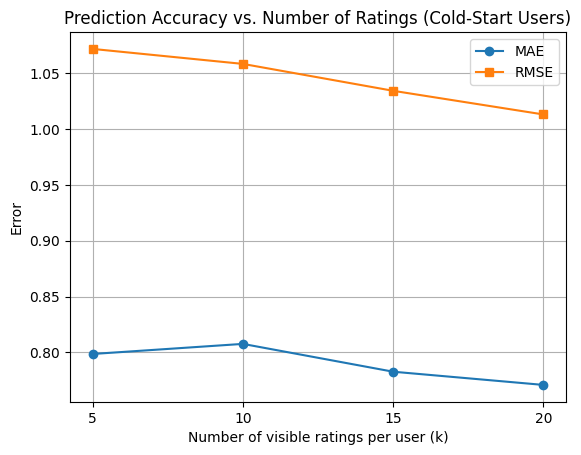

In [38]:
import matplotlib.pyplot as plt

#  k_visible   MAE vs RMSE
print(results_8_1_df)

plt.figure()

# MAE curve
plt.plot(results_8_1_df['k_visible'],
         results_8_1_df['MAE'],
         marker='o',
         label='MAE')

# RMSE curve
plt.plot(results_8_1_df['k_visible'],
         results_8_1_df['RMSE'],
         marker='s',
         label='RMSE')

plt.xlabel('Number of visible ratings per user (k)')
plt.ylabel('Error')
plt.title('Prediction Accuracy vs. Number of Ratings (Cold-Start Users)')
plt.xticks(results_8_1_df['k_visible'])  # show 5,10,15,20
plt.legend()
plt.grid(True)
plt.show()


(9.1): Build simple content features

In [39]:
# 9.1 – content-based signal: average rating per item
item_avg_rating = (
    ratings_train_final
    .groupby('movieId')['rating']
    .mean()
)

global_mean = ratings_train_final['rating'].mean()
print("Item avg_rating size:", len(item_avg_rating))


Item avg_rating size: 26742


 9.2 Generate hybrid predictions 

In [40]:
def hybrid_predictions_for_cold_item(i_cold, alpha=0.7, min_overlap=3):

    # CF part: your existing cluster-based predictions
    cf_preds = fast_predictions_for_cold_item(i_cold, min_overlap=min_overlap)
    if cf_preds is None or cf_preds.empty:
        return None
    
    # Content part: item average rating (falls back to global mean)
    item_mean = item_avg_rating.get(i_cold, global_mean)
    
    cf_preds = cf_preds.copy()
    cf_preds['pred_rating_hybrid'] = (
        alpha * cf_preds['pred_rating'] +
        (1 - alpha) * item_mean
    )
    
    return cf_preds[['userId', 'movieId', 'pred_rating_hybrid']]


In [41]:
cold_items_list = list(selected_items)[:10]

hybrid_all_preds_list = []   # all preds (for MAE/RMSE)
hybrid_top20_list = []       # top-20 per item (for recs)

for i_cold in cold_items_list:
    preds = hybrid_predictions_for_cold_item(i_cold, alpha=0.7)
    if preds is None or preds.empty:
        continue
    
    # all preds for evaluation
    hybrid_all_preds_list.append(
        preds[['userId', 'movieId', 'pred_rating_hybrid']].copy()
    )
    
    # top-20 for recommendation list
    preds_sorted = preds.sort_values('pred_rating_hybrid', ascending=False)
    hybrid_top20_list.append(preds_sorted.head(20).copy())

# combine
if hybrid_all_preds_list:
    hybrid_all_preds = pd.concat(hybrid_all_preds_list, ignore_index=True)
else:
    hybrid_all_preds = pd.DataFrame(columns=['userId', 'movieId', 'pred_rating_hybrid'])

if hybrid_top20_list:
    hybrid_recommendations = pd.concat(hybrid_top20_list, ignore_index=True)
    print("Hybrid recommendations (sample):")
    print(hybrid_recommendations.head(20))
else:
    hybrid_recommendations = pd.DataFrame(columns=['userId', 'movieId', 'pred_rating_hybrid'])
    print("No hybrid recommendations generated.")


Hybrid recommendations (sample):
    userId  movieId  pred_rating_hybrid
0    17535    77854                4.73
1    49711    77854                4.73
2   132177    77854                4.73
3    83458    77854                4.73
4    83460    77854                4.73
5    50038    77854                4.73
6    50035    77854                4.73
7     5721    77854                4.73
8    83541    77854                4.73
9   112891    77854                4.73
10   83573    77854                4.73
11   23151    77854                4.73
12   23162    77854                4.73
13  121273    77854                4.73
14   49887    77854                4.73
15   49868    77854                4.73
16  121302    77854                4.73
17  132078    77854                4.73
18   49837    77854                4.73
19   83718    77854                4.73


9.3.Evaluate hybrid vs cluster-only

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Ground truth from when you hid ratings for cold-start items
gt = hidden_item_ratings[['userId', 'movieId', 'rating']]

# Match hybrid predictions to ground truth
hybrid_eval = gt.merge(
    hybrid_all_preds,
    on=['userId', 'movieId'],
    how='inner'
)

print("Hybrid eval pairs:", len(hybrid_eval))

if len(hybrid_eval) == 0:
    print("No overlap between hybrid predictions and ground truth – cannot compute MAE/RMSE.")
    mae_hybrid = None
    rmse_hybrid = None
else:
    mae_hybrid = mean_absolute_error(
        hybrid_eval['rating'],
        hybrid_eval['pred_rating_hybrid']
    )
    rmse_hybrid = np.sqrt(mean_squared_error(
        hybrid_eval['rating'],
        hybrid_eval['pred_rating_hybrid']
    ))
    
    print(f"Hybrid MAE:  {mae_hybrid:.4f}")
    print(f"Hybrid RMSE: {rmse_hybrid:.4f}")


Hybrid eval pairs: 4882
Hybrid MAE:  0.6639
Hybrid RMSE: 0.8508


Compare with cluster-only (from Step 7.2)

In [43]:
if mae_hybrid is not None:
    print("\nComparison of cold-start item prediction:")
    print(f"Cluster-only MAE: {mae:.4f}")
    print(f"Hybrid MAE:       {mae_hybrid:.4f}")
    print(f"Cluster-only RMSE:{rmse:.4f}")
    print(f"Hybrid RMSE:      {rmse_hybrid:.4f}")



Comparison of cold-start item prediction:
Cluster-only MAE: 0.6429
Hybrid MAE:       0.6639
Cluster-only RMSE:0.9449
Hybrid RMSE:      0.8508


10 . Robustness of Cold-Start Handling

10.1 – Vary amount of information: k = 3, 5, 10, 20

In [44]:
k_values_10 = [3, 5, 10, 20]   

results_10 = []

for k in k_values_10:
    mae_k, rmse_k, _ = evaluate_for_k_visible(k, ratings, selected_users, random_state=42)
    if mae_k is not None:
        results_10.append((k, mae_k, rmse_k))
        print(f"k={k} visible ratings | MAE={mae_k:.4f} | RMSE={rmse_k:.4f}")

results_10_df = pd.DataFrame(results_10, columns=['k_visible', 'MAE', 'RMSE'])
print("\nRobustness results :")
print(results_10_df)


k=3 visible ratings | MAE=0.8474 | RMSE=1.1408
k=5 visible ratings | MAE=0.7986 | RMSE=1.0717
k=10 visible ratings | MAE=0.8076 | RMSE=1.0583
k=20 visible ratings | MAE=0.7709 | RMSE=1.0130

Robustness results :
   k_visible       MAE      RMSE
0          3  0.847448  1.140809
1          5  0.798599  1.071734
2         10  0.807630  1.058319
3         20  0.770897  1.013046


10.2  Plot how prediction quality degrades

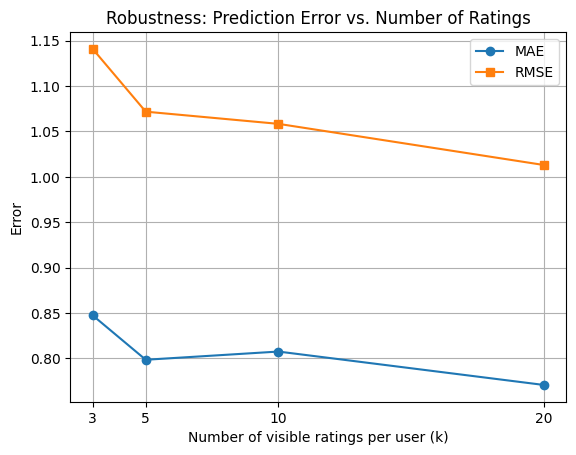

In [45]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot(results_10_df['k_visible'],
         results_10_df['MAE'],
         marker='o',
         label='MAE')

plt.plot(results_10_df['k_visible'],
         results_10_df['RMSE'],
         marker='s',
         label='RMSE')

plt.xlabel('Number of visible ratings per user (k)')
plt.ylabel('Error')
plt.title('Robustness: Prediction Error vs. Number of Ratings')
plt.xticks(results_10_df['k_visible'])   # show 3,5,10,20
plt.grid(True)
plt.legend()
plt.show()


10.3 Find minimum k with “acceptable” quality

In [46]:
# Best (lowest) RMSE across all k
best_rmse = results_10_df['RMSE'].min()
threshold = best_rmse * 1.10

acceptable_rows = results_10_df[results_10_df['RMSE'] <= threshold]

if len(acceptable_rows) == 0:
    print("No k meets the acceptable quality threshold.")
else:
    k_min_acceptable = int(acceptable_rows['k_visible'].min())
    print(f"\nMinimum number of ratings for acceptable quality : {k_min_acceptable}")
    print("Rows within threshold:")
    print(acceptable_rows)



Minimum number of ratings for acceptable quality : 5
Rows within threshold:
   k_visible       MAE      RMSE
1          5  0.798599  1.071734
2         10  0.807630  1.058319
3         20  0.770897  1.013046


### 11  Malak Amgad 221100451

In [47]:

cold_conf_analysis = cold_user_assignment.copy()

cold_conf_analysis['ratio'] = cold_conf_analysis.apply(
    lambda x: x['d_nearest'] / x['d_second'] if x['d_second'] > 1e-9 else 1.0, 
    axis=1
)

ambiguous_users = cold_conf_analysis[cold_conf_analysis['ratio'] > 0.7].copy()
confident_users = cold_conf_analysis[cold_conf_analysis['ratio'] <= 0.5].copy()

print(f"Total cold users: {len(cold_conf_analysis)}")
print(f"Ambiguous users (ratio > 0.7): {len(ambiguous_users)}")
print(f"Confident users (ratio <= 0.5): {len(confident_users)}")

def weighted_multi_cluster_predict(u_id, hidden_ground_truth):
    u_idx_map = {uid: i for i, uid in enumerate(cold_user_features['userId'])}
    idx = u_idx_map.get(u_id)
    if idx is None: return None
    
    dists = distances_to_centroids[idx]
    order = np.argsort(dists)
    c1, c2 = order[0], order[1]
    d1, d2 = dists[c1], dists[c2]
    
    w1 = 1.0 / (d1 + 1e-6)
    w2 = 1.0 / (d2 + 1e-6)
    total_w = w1 + w2
    w1 /= total_w
    w2 /= total_w
    
    user_gt = hidden_ground_truth[hidden_ground_truth['userId'] == u_id]
    if user_gt.empty: return None
    
    abs_errors = []
    
    for _, row in user_gt.iterrows():
        mid = row['movieId']
        actual = row['rating']
        
        users_c1 = user_cluster_map[user_cluster_map['cluster'] == c1]['userId']
        mean_c1 = ratings_train_final[
            (ratings_train_final['movieId'] == mid) & 
            (ratings_train_final['userId'].isin(users_c1))
        ]['rating'].mean()
        
        users_c2 = user_cluster_map[user_cluster_map['cluster'] == c2]['userId']
        mean_c2 = ratings_train_final[
            (ratings_train_final['movieId'] == mid) & 
            (ratings_train_final['userId'].isin(users_c2))
        ]['rating'].mean()
        
        if np.isnan(mean_c1): mean_c1 = global_mean
        if np.isnan(mean_c2): mean_c2 = global_mean
        
        pred = w1 * mean_c1 + w2 * mean_c2
        abs_errors.append(abs(pred - actual))
        
    if not abs_errors: return None
    return np.mean(abs_errors)

ambiguous_maes = []
for uid in ambiguous_users['userId'].values:
    mae = weighted_multi_cluster_predict(uid, hidden_user_ratings)
    if mae is not None:
        ambiguous_maes.append(mae)

avg_mae_weighted = np.mean(ambiguous_maes) if ambiguous_maes else 0.0
print(f"\nMAE for Ambiguous Users using Weighted Multi-Cluster: {avg_mae_weighted:.4f}")

Total cold users: 100
Ambiguous users (ratio > 0.7): 10
Confident users (ratio <= 0.5): 76

MAE for Ambiguous Users using Weighted Multi-Cluster: 0.7281


In [48]:
print("--- Strategy Comparison (Optimized) ---")
train_clustered = ratings_train_final.merge(user_cluster_map, on='userId', how='inner')
cluster_item_means = train_clustered.groupby(['cluster', 'movieId'])['rating'].mean().rename('pred_rating')
gt_data = hidden_user_ratings[hidden_user_ratings['userId'].isin(selected_users)].copy()
gt_data = gt_data.merge(cold_user_assignment[['userId', 'assigned_cluster']], on='userId', how='left')
gt_data = gt_data.join(cluster_item_means, on=['assigned_cluster', 'movieId'])
gt_data['pred_rating'] = gt_data['pred_rating'].fillna(global_mean)
mae_strat_1 = (gt_data['rating'] - gt_data['pred_rating']).abs().mean()
print(f"Strategy 1 (Cluster-Based Mean): MAE = {mae_strat_1:.4f}")
gt_strat_2 = hidden_user_ratings[hidden_user_ratings['userId'].isin(selected_users)].copy()
gt_strat_2['pred_rating'] = gt_strat_2['movieId'].map(item_avg_rating).fillna(global_mean)
mae_strat_2 = (gt_strat_2['rating'] - gt_strat_2['pred_rating']).abs().mean()
print(f"Strategy 2 (Global Item Mean):   MAE = {mae_strat_2:.4f}")
gt_strat_3 = hidden_user_ratings[hidden_user_ratings['userId'].isin(selected_users)]
mae_strat_3 = (gt_strat_3['rating'] - global_mean).abs().mean()
print(f"Strategy 3 (Global Constant):    MAE = {mae_strat_3:.4f}")

--- Strategy Comparison (Optimized) ---
Strategy 1 (Cluster-Based Mean): MAE = 0.7444
Strategy 2 (Global Item Mean):   MAE = 0.7112
Strategy 3 (Global Constant):    MAE = 0.8114


In [50]:
import numpy as np
import pandas as pd
def custom_kmeans_optimized(X, k, max_iters=100, random_state=42):
    rng = np.random.RandomState(random_state)
    n_samples, n_features = X.shape
    indices = rng.choice(n_samples, k, replace=False)
    centroids = X[indices]
    for _ in range(max_iters):
        dists_sq = np.sum((X[:, None, :] - centroids[None, :, :])**2, axis=2)
        labels = np.argmin(dists_sq, axis=1)
        counts = np.bincount(labels, minlength=k)
        safe_counts = np.where(counts == 0, 1, counts)
        new_centroids = np.zeros_like(centroids)
        for d in range(n_features):
            sums = np.bincount(labels, weights=X[:, d], minlength=k)
            new_centroids[:, d] = sums / safe_counts
        mask_empty = (counts == 0)
        new_centroids[mask_empty] = centroids[mask_empty]
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    return centroids, labels
k_options = [5, 10, 20, 50]
granularity_results = []
X_users = user_feature_vector[['z_score']].values
print("--- Cluster Granularity Analysis (Optimized) ---")
for k_trial in k_options:
    centroids_t, labels_t = custom_kmeans_optimized(X_users, k_trial, random_state=99)
    user_map_t = pd.DataFrame({
        'userId': user_feature_vector['userId'],
        'cluster': labels_t
    })
    train_with_cluster = ratings_train_final.merge(user_map_t, on='userId', how='inner')
    cluster_item_means = train_with_cluster.groupby(['cluster', 'movieId'])['rating'].mean().rename('pred_rating')
    cold_z_t = cold_user_features['z_score'].values.reshape(-1, 1)
    dists_t = np.abs(cold_z_t - centroids_t.reshape(1, -1))
    assigned_t = np.argmin(dists_t, axis=1)
    cold_assignment_df = pd.DataFrame({
        'userId': cold_user_features['userId'],
        'assigned_cluster': assigned_t
    })
    eval_df = hidden_user_ratings.merge(cold_assignment_df, on='userId', how='inner')
    eval_df = eval_df.join(cluster_item_means, on=['assigned_cluster', 'movieId'], how='left')
    eval_df['pred_rating'] = eval_df['pred_rating'].fillna(global_mean)
    mae_k = (eval_df['rating'] - eval_df['pred_rating']).abs().mean()
    granularity_results.append((k_trial, mae_k))
    print(f"K={k_trial} | Cold-Start MAE={mae_k:.4f}")
granularity_df = pd.DataFrame(granularity_results, columns=['K', 'MAE'])
print("\nDiscussion:")
best_k = granularity_df.loc[granularity_df['MAE'].idxmin()]
print(f"Best performance achieved at K={int(best_k['K'])} with MAE={best_k['MAE']:.4f}")
if best_k['K'] <= 10:
    print("Smaller K (fewer, larger clusters) worked better. This suggests data availability is crucial; larger clusters ensure more items have ratings, reducing sparsity.")
else:
    print("Larger K (more, smaller clusters) worked better. This suggests cluster specificity is crucial; users are grouped more tightly by preference, even if data is sparser.")

--- Cluster Granularity Analysis (Optimized) ---
K=5 | Cold-Start MAE=0.7012
K=10 | Cold-Start MAE=0.6930
K=20 | Cold-Start MAE=0.6936
K=50 | Cold-Start MAE=0.7008

Discussion:
Best performance achieved at K=10 with MAE=0.6930
Smaller K (fewer, larger clusters) worked better. This suggests data availability is crucial; larger clusters ensure more items have ratings, reducing sparsity.


In [52]:
print("\n--- Confidence-Based Filtering (Optimized) ---")

train_clustered = ratings_train_final.merge(user_cluster_map, on='userId', how='inner')

cluster_item_stats = train_clustered.groupby(['cluster', 'movieId'])['rating'].agg(
    ['count', 'mean']
).reset_index().rename(columns={'count': 'n_raters', 'mean': 'pred_rating'})

pred_conf_df = hidden_user_ratings.copy()

pred_conf_df = pred_conf_df.merge(
    cold_user_assignment[['userId', 'assigned_cluster', 'confidence']], 
    on='userId', 
    how='inner'
)

pred_conf_df = pred_conf_df.merge(
    cluster_item_stats, 
    left_on=['assigned_cluster', 'movieId'], 
    right_on=['cluster', 'movieId'], 
    how='left'
)

pred_conf_df['n_raters'] = pred_conf_df['n_raters'].fillna(0)
pred_conf_df['pred_rating'] = pred_conf_df['pred_rating'].fillna(global_mean)

pred_conf_df['support_conf'] = np.minimum(pred_conf_df['n_raters'] / 20.0, 1.0)

pred_conf_df['final_conf'] = pred_conf_df['confidence'] * pred_conf_df['support_conf']

threshold = pred_conf_df['final_conf'].median()
high_conf_df = pred_conf_df[pred_conf_df['final_conf'] >= threshold]

mae_all = np.mean(np.abs(pred_conf_df['rating'] - pred_conf_df['pred_rating']))
mae_high_conf = np.mean(np.abs(high_conf_df['rating'] - high_conf_df['pred_rating']))

print(f"Overall MAE (All Predictions): {mae_all:.4f}")
print(f"High Confidence MAE (Top 50%): {mae_high_conf:.4f}")
print(f"Improvement: {mae_all - mae_high_conf:.4f}")


--- Confidence-Based Filtering (Optimized) ---
Overall MAE (All Predictions): 0.7444
High Confidence MAE (Top 50%): 0.7809
Improvement: -0.0364
